In [44]:
#Loading Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # Import confusion_matrix
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [45]:
#Loading in Files
file_path = '/content/project_adult.csv'
file_path_valid  = '/content/project_validation_inputs.csv'

df = pd.read_csv(file_path, na_values='?')
df_valid = pd.read_csv(file_path_valid, na_values='?')

In [46]:
#Define a Function to Preprocess the Data
def preprocess_data(df):

  #Change income to a binary variable
  if 'income' in df.columns:
    df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

  #Get rid of education because it's the same as education num but not ordinal

  #drop na
  if 'workclass' in df.columns:
     df['workclass'].replace('?', np.nan)

  if 'occupation' in df.columns:
     df['occupation'].replace('?', np.nan)

  if 'native-country' in df.columns:
    df['native-country'].replace('?', np.nan)

  # Select categorical columns (object or category types)
  categorical_cols = df.select_dtypes(include=['object', 'category']).columns

  # Initialize encoder
  le = LabelEncoder()

  # Apply LabelEncoder to each categorical column in place
  for col in categorical_cols:
      df[col] = le.fit_transform(df[col])

  return df

In [47]:
#Actually preprocess data
df = preprocess_data(df)
df_valid = preprocess_data(df_valid)

In [48]:
# split data into training and test datasets
train = df.drop('income', axis=1) # Features are all columns except 'Unnamed: 0' and 'income'
X = train
y = df['income'] # Target is the 'income' column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [49]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Convert outputs to numpy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [50]:
###LIST OF HYPERPARAMETERS THAT NEED TUNING
#Batch size (start with a standard size of 50)

#Number of Epochs (test out multiple)

#Number of Hidden Layers and number of computed values in hidden layers


In [51]:
#Import Training and Test sets as tensors
X_train_t = torch.from_numpy(X_train_scaled).float()
X_test_t = torch.from_numpy(X_test_scaled).float()
y_train_t = torch.from_numpy(y_train).float()
y_test_t = torch.from_numpy(y_test).float()

#Create a Tensor Dataset for training and test sets
Tensor_train = TensorDataset(X_train_t, y_train_t)

In [52]:
#Shuffling training batches (starting with 50 to test)
torch.manual_seed(67)
train_dl = DataLoader(Tensor_train, batch_size=50, shuffle=True)

In [53]:
# Creating model class for testing model
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        # new hidden layer (keeps same signature)
        self.layer_hidden = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.layer2 = nn.Linear(hidden_size, 2)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        # pass through the extra hidden layer
        x = self.layer_hidden(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.Tanh()(x)
        return x

In [54]:
#Setting Parameters
input_size = X_train_t.shape[1]
hidden_size = 64

In [55]:
#Set model and Loss function
model = Model(input_size, hidden_size)
loss_fn = nn.CrossEntropyLoss()

In [56]:
#Set learning Rate and Optimizer
# add dropout

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [57]:
num_epochs = 600
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

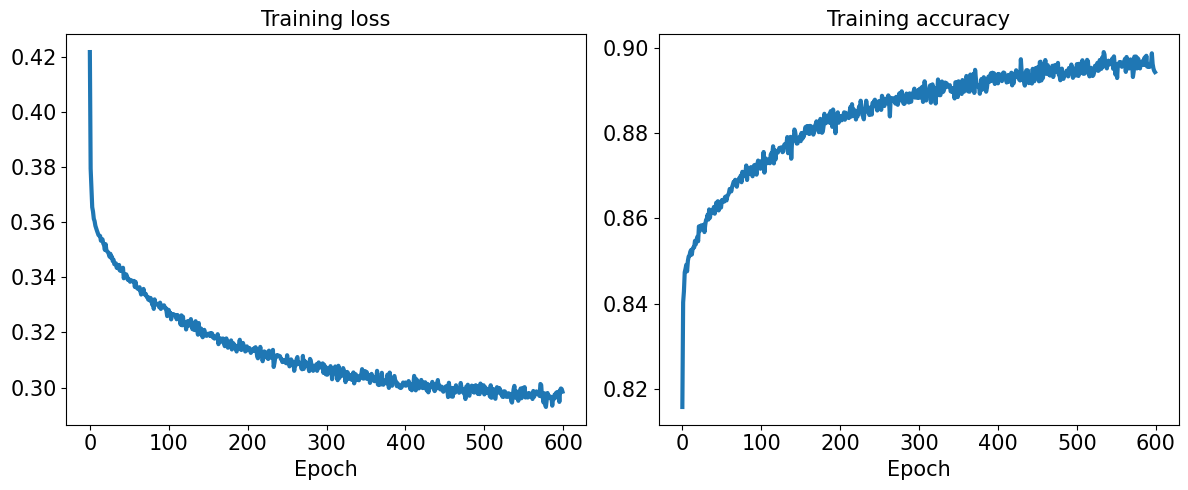

In [58]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

In [59]:
# print out accuracy numbers and results
print(f'Accuracy: {accuracy_hist[-1]}')
#print other scores
print(f'Loss: {loss_hist[-1]}')

# Calculate predictions for confusion matrix
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    y_pred_probs = model(X_test_t)
    y_pred = torch.argmax(y_pred_probs, dim=1).numpy()

#print confusion matrix
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}')
#print f1 scores for class -1 and 1
from sklearn.metrics import f1_score
print(f'F1 Score: {f1_score(y_test, y_pred)}')

print(f'F1 Score: {f1_score(y_test, y_pred)}')


Accuracy: 0.8943756818771362
Loss: 0.29848457100278347
Confusion Matrix:
[[3625  331]
 [ 531  723]]
F1 Score: 0.6265164644714039
F1 Score: 0.6265164644714039


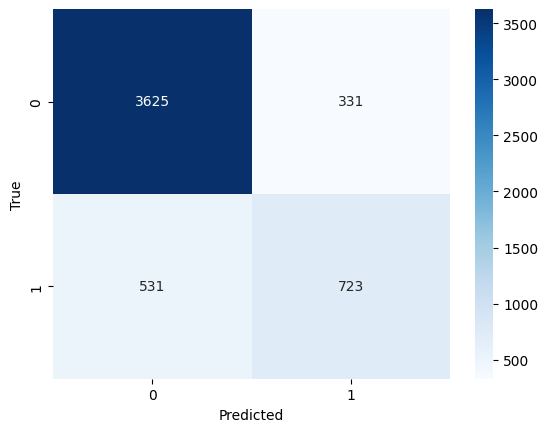

In [60]:
#illistrate confusion matrix using matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
#plot cm using heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [61]:
#Run model on test data
# --- Evaluate on test data in a training-loop style ---
model.eval()
with torch.no_grad():
    pred = model(X_test_t)
    is_correct = (torch.argmax(pred, dim=1) == y_test_t).float()
    print(f'Test accuracy: {is_correct.mean():.4f}')
    #print loss
    loss = loss_fn(pred, y_test_t.long())
    print(f'Test loss: {loss.item():.4f}')

Test accuracy: 0.8345
Test loss: 0.4037


In [62]:

#scale the validation dataset
df_valid_scaled = scaler.transform(df_valid)

# Convert to Tensor and run inference
X_valid_t = torch.from_numpy(df_valid_scaled).float()

valid_dl = DataLoader(TensorDataset(X_valid_t, torch.zeros(len(X_valid_t))), batch_size=256, shuffle=False)

model.eval()
preds = []
with torch.no_grad():
    for (xb, _) in valid_dl:
        out = model(xb)              # <--- your model (unchanged)
        pred = torch.argmax(out, dim=1).cpu().numpy()  # class ids 0/1
        preds.append(pred)

preds = np.concatenate(preds)

# If your model trained on string labels and you later mapped them to 0/1,
# make sure class 1 corresponds to '>50K'. If it does, map to -1/1 like this:
mapped = np.where(preds == 1, 1, -1)

# Save exactly as required
out_path = 'Group_#_MLP_PredictedOutputs.csv'  # replace # with your group number
pd.Series(mapped).to_csv(out_path, index=False, header=False)
print(f"Saved validation predictions to {out_path}")

Saved validation predictions to Group_#_MLP_PredictedOutputs.csv
